## The goal: Now that we have some maps of global wind variances from CLUBB, can we get interesting regions to focus on? 
<br>
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 20 Aug 2020 <br>

In [39]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import Ngl
import numpy
import Nio
import os
import numpy as np 
import xarray as xr
from datetime import date, timedelta
import pandas as pd 
import regionmask


## Read in data

In [5]:
# Set up directories 
dataDir    = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd    = '_CLUBBwinds.nc'
nameEnd_UV = '_UV.nc'

decadeList = ['1951-59','1960-69', '1970-79','1980-89','1990-99','2000-14']


In [3]:
# Read in example file to get some constant fields
testName = dataDir+nameStart+'1990-01.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landFrac = np.squeeze(testDF.LANDFRAC.values)
# Define as 'land' gridcell if land fraction > 0.5
landMask = np.zeros([len(lat),len(lon)])
landMask[landFrac > 0.5] = 1


In [6]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    fileName = dataDir+nameStart+decadeList[iDec]+nameEnd
    dataDF   = xr.open_dataset(fileName, decode_times=True)
    dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    UVfile = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
    windDF = xr.open_dataset(UVfile, decode_times=True)
    windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
#     PSfile = dataDir+nameStart+decadeList[iDec]+'_PS.nc'
#     presDF = xr.open_dataset(PSfile, decode_times=True)
#     presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullDF = dataDF
        fullUV = windDF
#         fullPS = presDF
    else:
        fullDF = xr.concat([fullDF, dataDF], dim="time")
        fullUV = xr.concat([fullUV, windDF], dim="time")
#         fullPS = xr.concat([fullPS, presDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullDF['time']))
    

<ipython-input-6-ed01e11f2d3f>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-6-ed01e11f2d3f>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()


Done with decade  1951-59  ... 
    Number of times saved:  108
Done with decade  1960-69  ... 
    Number of times saved:  228
Done with decade  1970-79  ... 
    Number of times saved:  348
Done with decade  1980-89  ... 
    Number of times saved:  468
Done with decade  1990-99  ... 
    Number of times saved:  588
Done with decade  2000-14  ... 
    Number of times saved:  768


Since ideally, I'd like to be able to access the time attributes fairly easily, I'm going to put those into a separate pandas array.<br>
That way they can be indexed via dates.year, dates.month, etc. <br><br>
Note: monthly averages are saved at the first time step of the next month. So to get January averages for example, you'd want dates.month==2. 

In [7]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullDF['time'].values) 


## Flip levels

In [10]:
# Read into individual arrays for easy access

UP2 = fullDF.UP2_CLUBB      # Zonal velocity variance (m2/s2)
VP2 = fullDF.VP2_CLUBB      # Meridional velocity variance (m2/s2)
WP2 = fullDF.WP2_CLUBB      # Vertical velocity variance (m2/s2)
WP3 = fullDF.WP3_CLUBB      # Third moment vertical velocity (m3/s3)

U   = fullUV.U              # Zonal wind (m/s)
V   = fullUV.V              # Meridional wind (m/s)


I think the easiest way for me to actually look at low levels is to flip along the vertical axis. But one thing to keep in mind is that the CLUBB velocities are output at the <i>interfaces</i> between model levels, while U and V averages are reported at the <i>middle</i> of the level. So there's a bit of an offset there. 

In [16]:
# Flip along vertical (level) axis, so that index 0 is surface 

UP2 = np.flip(UP2, axis=1)
VP2 = np.flip(VP2, axis=1)
WP2 = np.flip(WP2, axis=1)
WP3 = np.flip(WP3, axis=1)

U   = np.flip(U, axis=1)
V   = np.flip(V, axis=1)

# Save levels themselves to arrays and flip them 
lev_interface = np.flip(fullDF.ilev.values)
lev_middle    = np.flip(fullUV.lev.values)


In [17]:
print('interfaces: ', lev_interface)
print()
print('middles: ', lev_middle)

interfaces:  [1000.          985.11219025  967.53862454  947.43233453  924.96446241
  900.32463148  873.71586636  845.35366669  796.36307061  730.44589162
  652.33296901  567.22442061  482.14992881  409.83521938  348.36658835
  296.11721635  251.70441717  213.95282075  181.86335266  154.58680689
  131.40127063  111.6932109    94.94104236   80.70141822   66.80049747
   56.24049902   47.11449891   39.27300125   29.7346756    18.55531707
   10.15794743    5.03169186    2.25523952]

middles:  [992.55609512 976.32540739 957.48547954 936.19839847 912.64454694
 887.02024892 859.53476653 820.85836865 763.40448111 691.38943031
 609.77869481 524.68717471 445.9925741  379.10090387 322.24190235
 273.91081676 232.82861896 197.9080867  168.22507977 142.99403876
 121.54724076 103.31712663  87.82123029  73.75095785  61.52049825
  51.67749897  43.19375008  35.92325002  24.61222     14.35663225
   7.59481965   3.64346569]


## Quick look at U and V - time average maps again? 

In [19]:
# Average over all months 
U_timeMean = np.squeeze(np.nanmean(U, axis=0))
V_timeMean = np.squeeze(np.nanmean(V, axis=0))


In [20]:
np.shape(V_timeMean)

(32, 192, 288)

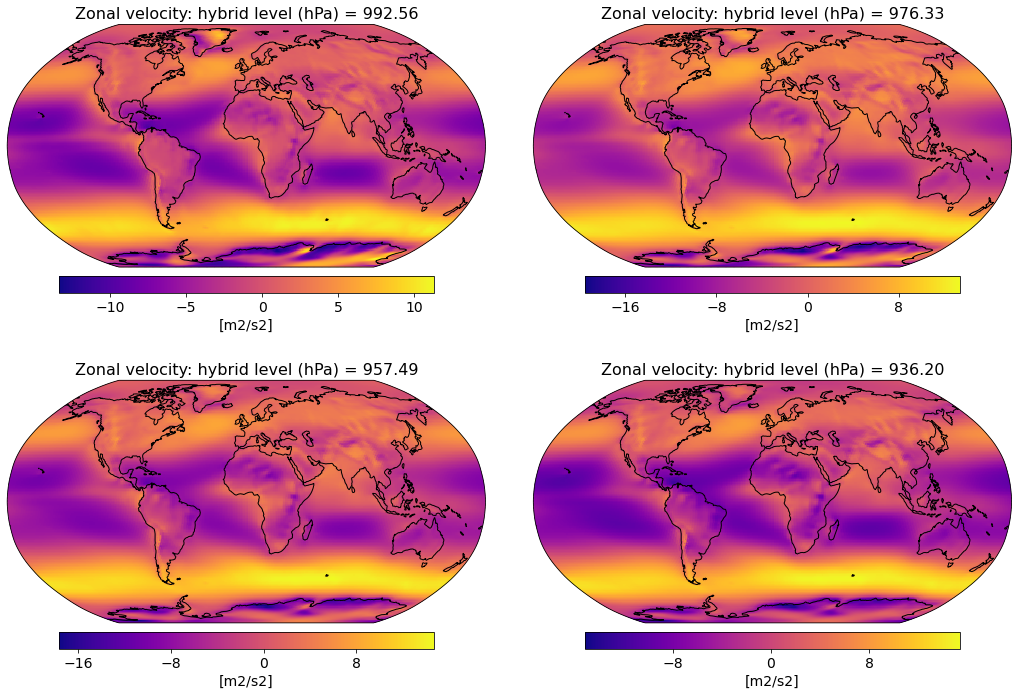

In [21]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    U_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(U_timeMean[iLev,:,:]), dataDF.lon)
    
#     if iLev==0:
#         cMax = 1
#     else: 
#         cMax = 0.5
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,U_cyclic,
#                                         vmin=0,
#                                         vmax=cMax,
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Zonal velocity: hybrid level (hPa) = %.2f' % lev_middle[iLev], fontsize=16)



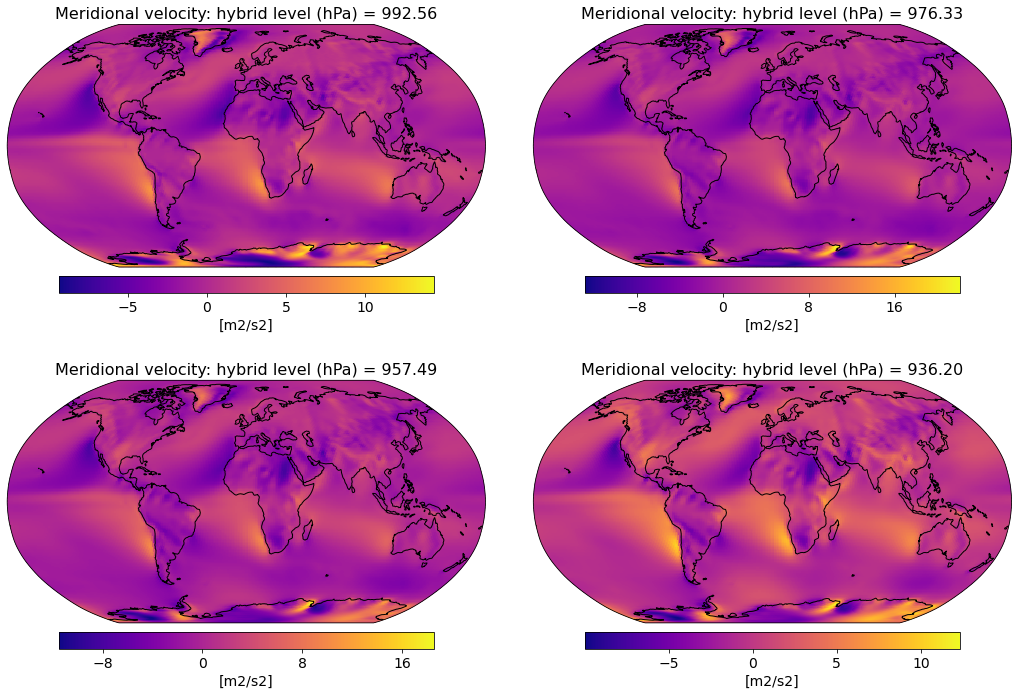

In [22]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    V_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(V_timeMean[iLev,:,:]), dataDF.lon)
    
#     if iLev==0:
#         cMax = 1
#     else: 
#         cMax = 0.5
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,V_cyclic,
#                                         vmin=0,
#                                         vmax=cMax,
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Meridional velocity: hybrid level (hPa) = %.2f' % lev_middle[iLev], fontsize=16)


## Global maps at lowest level U and second interface of UP2_CLUBB

In [26]:
# --- Get seasonal means --- #

iDJF = np.where((dates.month==1) | (dates.month<=3))[0]
iMAM = np.where((dates.month>=4) & (dates.month<=6))[0]
iJJA = np.where((dates.month>=7) & (dates.month<=9))[0]
iSON = np.where((dates.month>=10) & (dates.month<=12))[0]

# DJF 
UP2_DJFmean = np.squeeze(np.nanmean(UP2[iDJF,:,:,:], 0))
VP2_DJFmean = np.squeeze(np.nanmean(VP2[iDJF,:,:,:], 0))
WP2_DJFmean = np.squeeze(np.nanmean(WP2[iDJF,:,:,:], 0))
WP3_DJFmean = np.squeeze(np.nanmean(WP3[iDJF,:,:,:], 0))
U_DJFmean   = np.squeeze(np.nanmean(U[iDJF,:,:,:], 0))
V_DJFmean   = np.squeeze(np.nanmean(V[iDJF,:,:,:], 0))
print('Done with DJF means')

# MAM 
UP2_MAMmean = np.squeeze(np.nanmean(UP2[iMAM,:,:,:], 0))
VP2_MAMmean = np.squeeze(np.nanmean(VP2[iMAM,:,:,:], 0))
WP2_MAMmean = np.squeeze(np.nanmean(WP2[iMAM,:,:,:], 0))
WP3_MAMmean = np.squeeze(np.nanmean(WP3[iMAM,:,:,:], 0))
U_MAMmean   = np.squeeze(np.nanmean(U[iMAM,:,:,:], 0))
V_MAMmean   = np.squeeze(np.nanmean(V[iMAM,:,:,:], 0))
print('Done with MAM means')

# JJA
UP2_JJAmean = np.squeeze(np.nanmean(UP2[iJJA,:,:,:], 0))
VP2_JJAmean = np.squeeze(np.nanmean(VP2[iJJA,:,:,:], 0))
WP2_JJAmean = np.squeeze(np.nanmean(WP2[iJJA,:,:,:], 0))
WP3_JJAmean = np.squeeze(np.nanmean(WP3[iJJA,:,:,:], 0))
U_JJAmean   = np.squeeze(np.nanmean(U[iJJA,:,:,:], 0))
V_JJAmean   = np.squeeze(np.nanmean(V[iJJA,:,:,:], 0))
print('Done with JJA means')

# SON
UP2_SONmean = np.squeeze(np.nanmean(UP2[iSON,:,:,:], 0))
VP2_SONmean = np.squeeze(np.nanmean(VP2[iSON,:,:,:], 0))
WP2_SONmean = np.squeeze(np.nanmean(WP2[iSON,:,:,:], 0))
WP3_SONmean = np.squeeze(np.nanmean(WP3[iSON,:,:,:], 0))
U_SONmean   = np.squeeze(np.nanmean(U[iSON,:,:,:], 0))
V_SONmean   = np.squeeze(np.nanmean(V[iSON,:,:,:], 0))
print('Done with SON means')


Done with DJF means
Done with MAM means
Done with JJA means
Done with SON means


In [30]:
# Get cyclic point for all seasons in one array 
UP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
U_seasonal   = np.full([4, len(lat), len(lon)+1], np.nan)

UP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[1,:,:]), dataDF.lon)
UP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[1,:,:]), dataDF.lon)
UP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[1,:,:]), dataDF.lon)
UP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[1,:,:]), dataDF.lon)

U_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(U_DJFmean[1,:,:]), dataDF.lon)
U_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(U_MAMmean[1,:,:]), dataDF.lon)
U_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(U_JJAmean[1,:,:]), dataDF.lon)
U_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(U_SONmean[1,:,:]), dataDF.lon)

# Array with season names 
seasonName = ['DJF','MAM','JJA','SON']


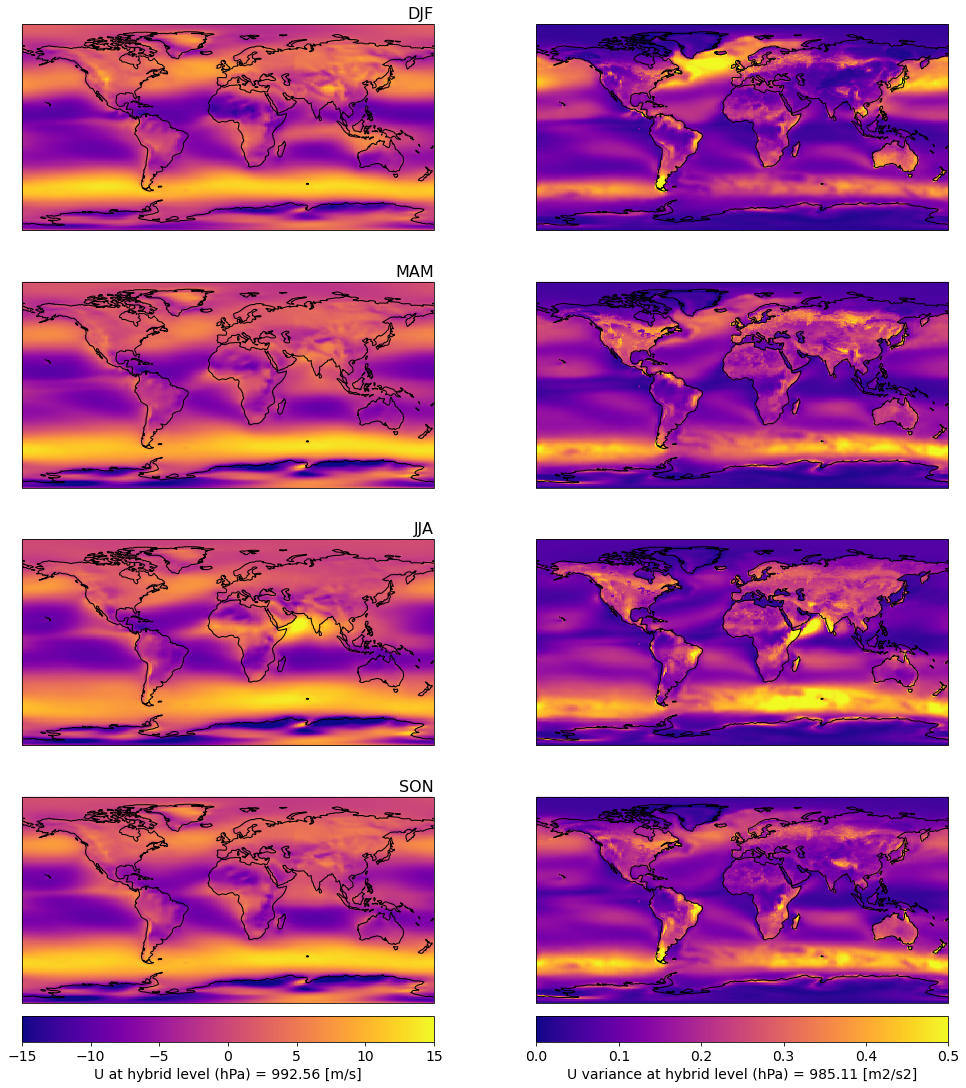

In [38]:
# Set up figure 
fig, axs = plt.subplots(4,2, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.25,wspace = 0.05)
#Put axs handles in array, axs 
axs = axs.ravel()

# Index used for plotting 
pltInd = 0 
for iSeason in range(4):
    # Set US extent
    #axs[pltInd].set_extent([220,300,20,60])
    axs[pltInd].set_global()
    axs[pltInd+1].set_global()
    
    # Contour U itself
    contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(U_seasonal[iSeason,:,:]),
                                        vmin=-15,
                                        vmax=15,
                                        cmap='plasma')
    # Add colorbars to bottom panels 
    if pltInd==6:
        # Handle colorbar for U 
        ax_position = axs[pltInd].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
        cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
        # Control number of ticks via 'ticker' in matplotlib 
        tick_locator = ticker.MaxNLocator(nbins=7)
        cbar.locator = tick_locator
        cbar.update_ticks()
        # Set label and fontsize
        cbar.set_label('U at hybrid level (hPa) = %.2f [m/s]' % lev_middle[0],fontsize=14)
        cbar.ax.tick_params(labelsize=14)
    
    # Contour the variance of U
    contour_plot = axs[pltInd+1].pcolormesh(lon_cyclic,lat,np.squeeze(UP2_seasonal[iSeason,:,:]),
                                        vmin=0,
                                        vmax=0.5,
                                        cmap='plasma')
        # Add colorbars to bottom panels 
    if pltInd==6:
        # Handle colorbar for U variance 
        ax_position = axs[pltInd+1].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
        cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
        # Control number of ticks via 'ticker' in matplotlib 
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        # Set label and fontsize
        cbar.set_label('U variance at hybrid level (hPa) = %.2f [m2/s2]' % lev_interface[1],fontsize=14)
        cbar.ax.tick_params(labelsize=14)
    
    # Add continent outlines 
    axs[pltInd].coastlines()
    axs[pltInd+1].coastlines()

    # Add some helpful labels 
    axs[pltInd].set_title(seasonName[iSeason], fontsize=16,loc='right')
    
    # Increment plot index by two to start on next row 
    pltInd = pltInd+2 


## Let's use the SREX regions as initial definitions

Useful example in documentation: https://regionmask.readthedocs.io/en/stable/notebooks/mask_3D.html



In [40]:
# Get basic info on SREX regions 
regionmask.defined_regions.srex

<regionmask.Regions>
Name:     SREX
Source:   Seneviratne et al., 2012 (https://www.ipcc.ch/site/assets/uploads/2...

Regions:
  1  ALA        Alaska/N.W. Canada
  2  CGI      Canada/Greenl./Icel.
  3  WNA          W. North America
  4  CNA          C. North America
  5  ENA          E. North America
..   ...                       ...
 22  EAS                   E. Asia
 23  SAS                   S. Asia
 24  SEA                 S.E. Asia
 25  NAU              N. Australia
 26  SAU  S. Australia/New Zealand

[26 regions]

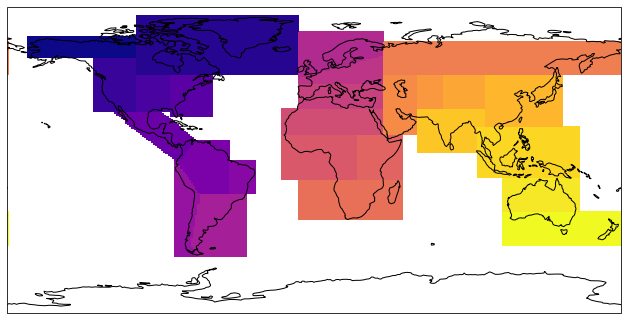

In [119]:
# Plot the mask we'll use 
f, ax = plt.subplots(figsize=(11, 8),subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()

mask2D = regionmask.defined_regions.srex.mask(lon, lat)
mask2D.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='plasma');


In [150]:
# Create 3D mask of the regions mapped out above 
#   (better for actually getting averages and masking out other regions)
RegMask = regionmask.defined_regions.srex.mask_3D(lon, lat)

In [80]:
# --- Get regional (weighted) averages of U and UP2 --- # 

# Define weights as cos of latitude 
weights = np.cos(np.deg2rad(lat))

U_regionalMean   = U[:,0,:,:].weighted(RegMask * weights).mean(dim=("lat", "lon"))
UP2_regionalMean = UP2[:,1,:,:].weighted(RegMask * weights).mean(dim=("lat", "lon"))


In [86]:
np.shape(U_regionalMean)

(768, 26)

### Scatter plot of regional mean U vs. variance of U

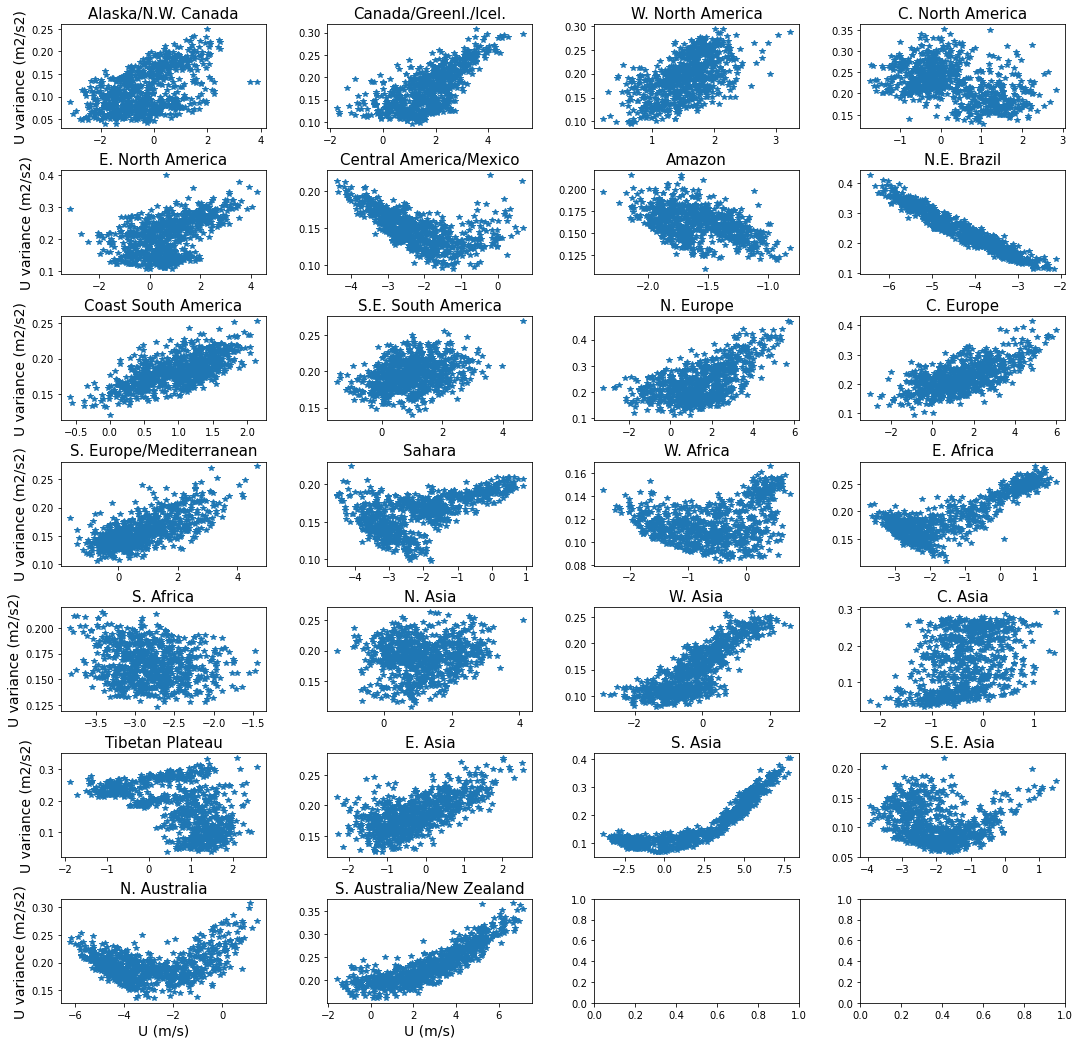

In [100]:
# Set up figure 
fig, axs = plt.subplots(7,4, figsize=(18, 18))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

for iReg in range(len(RegMask.names)):
    axs[iReg].plot(U_regionalMean[:,iReg],UP2_regionalMean[:,iReg],'*')
    
    axs[iReg].set_title(RegMask.names.values[iReg],fontsize=15)
    
    # Set axis labels only for outside plots 
    if iReg>=24:
        axs[iReg].set_xlabel('U (m/s)', fontsize=14)
    
    if ((iReg==0) | (iReg==4) | (iReg==8) | (iReg==12) | (iReg==16) | (iReg==20) | (iReg==24)):
        axs[iReg].set_ylabel('U variance (m2/s2)',fontsize=14)
        


**Maybe  color code seasonally?**

In [ ]:
iDJF = np.where((dates.month==1) | (dates.month<=3))[0]
iMAM = np.where((dates.month>=4) & (dates.month<=6))[0]
iJJA = np.where((dates.month>=7) & (dates.month<=9))[0]
iSON = np.where((dates.month>=10) & (dates.month<=12))[0]


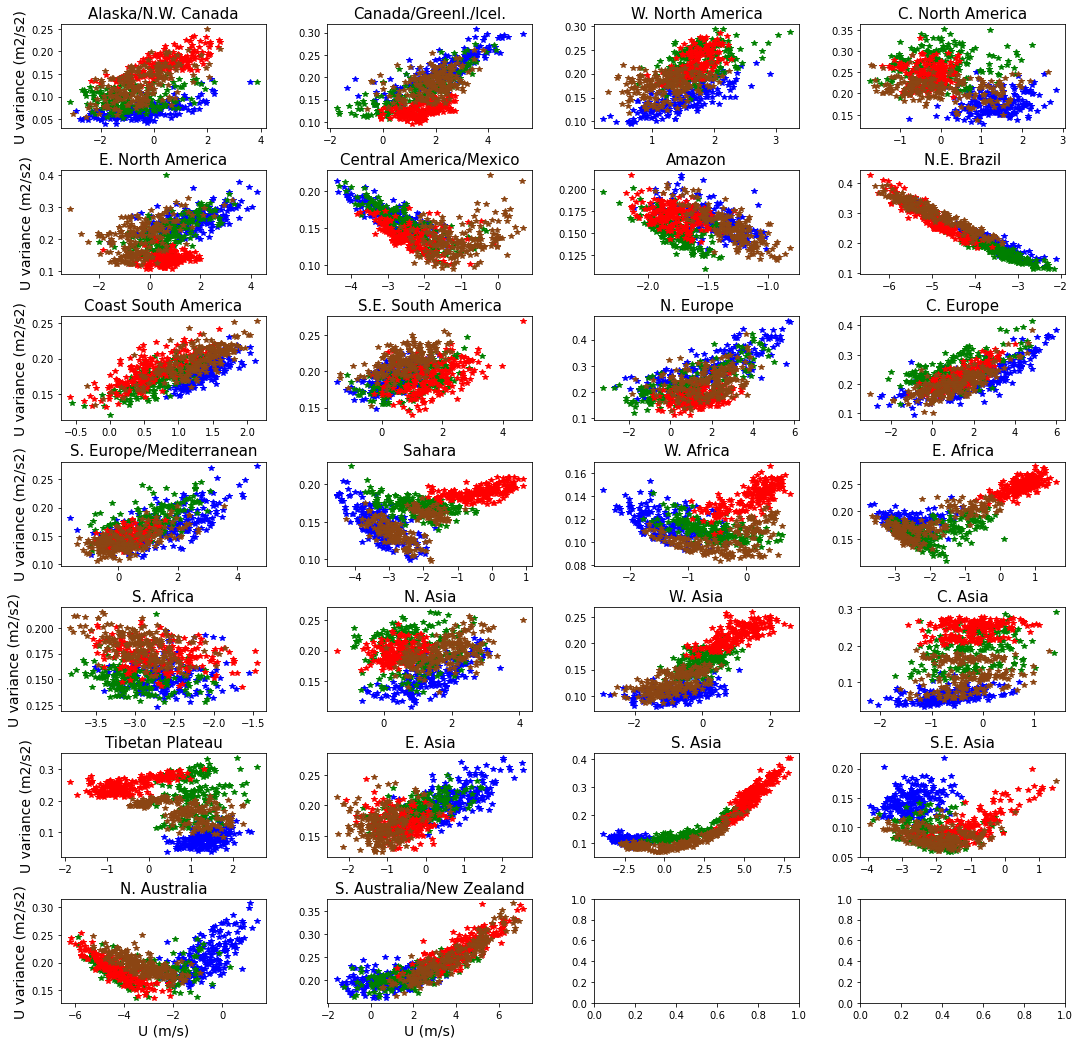

In [135]:
# Set up figure 
fig, axs = plt.subplots(7,4, figsize=(18, 18))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

for iReg in range(len(RegMask.names)):
    # Color code by region
    axs[iReg].plot(U_regionalMean[iDJF,iReg],UP2_regionalMean[iDJF,iReg],'b*')
    axs[iReg].plot(U_regionalMean[iMAM,iReg],UP2_regionalMean[iMAM,iReg],'g*')
    axs[iReg].plot(U_regionalMean[iJJA,iReg],UP2_regionalMean[iJJA,iReg],'r*')
    axs[iReg].plot(U_regionalMean[iSON,iReg],UP2_regionalMean[iSON,iReg],'*',color='saddlebrown')   
    
    # Set title
    axs[iReg].set_title(RegMask.names.values[iReg],fontsize=15)

    # If want easily comparable axes..
    #axs[iReg].set_ylim([0.03,0.45])
    
    # Set axis labels only for outside plots 
    if iReg>=24:
        axs[iReg].set_xlabel('U (m/s)', fontsize=14)
    
    if ((iReg==0) | (iReg==4) | (iReg==8) | (iReg==12) | (iReg==16) | (iReg==20) | (iReg==24)):
        axs[iReg].set_ylabel('U variance (m2/s2)',fontsize=14)
        



### Can we come up with some index to represent how poorly or well the mean wind works?

In [140]:
# Maybe look at std rather than variance? Same units that way. 
Ustd_regional = np.sqrt(UP2_regionalMean)

# Could look at std as fraction of wind speed 
STDfraction = Ustd_regional / np.abs(U_regionalMean)


In [160]:
# Take average over time 
avgFraction = np.nanmean(STDfraction,axis=0)
   
print('             Region             Ustd / np.abs(U) [time mean]')
print('         --------------       ------------------------------')
for iReg in range(len(RegMask.names)):
    print('%24s  %14.3f' % (RegMask.names.values[iReg], avgFraction[iReg]))


             Region             Ustd / np.abs(U) [time mean]
         --------------       ------------------------------
      Alaska/N.W. Canada           1.149
    Canada/Greenl./Icel.           0.758
        W. North America           0.312
        C. North America           5.048
        E. North America           3.312
  Central America/Mexico           0.606
                  Amazon           0.258
             N.E. Brazil           0.116
     Coast South America          13.950
      S.E. South America           1.729
               N. Europe           2.492
               C. Europe           1.607
 S. Europe/Mediterranean          22.399
                  Sahara           0.688
               W. Africa           2.635
               E. Africa           2.369
               S. Africa           0.148
                 N. Asia           2.240
                 W. Asia           2.165
                 C. Asia           3.433
         Tibetan Plateau           2.097
                 

In [164]:
np.shape(avgFraction[avgFraction>5])

(3,)

### Sanity check this works 

In [74]:
sel  = RegMask.sel(region=3)
selU = U[:,0,:,:].where(sel)


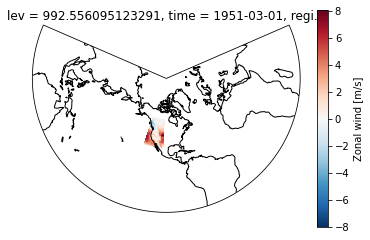

In [76]:
proj = ccrs.LambertConformal(central_longitude=-100)

ax = plt.subplot(111, projection=proj)

selU.isel(time=1).plot(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();